# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
import keras
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

In [ ]:
train = "seg_train"
test = "seg_test"
pred = "seg_pred"

# Viewing Data

### Counting Images in training dataset

In [3]:
# Define the path to the training data
train_path = Path(train)  # replace with your actual path

# Iterate over subfolders in 'seg_train' directory
for folder in (train_path / 'seg_train').iterdir():
    if folder.is_dir():
        # Count the number of '.jpg' files in each folder
        files = list(folder.glob('*.jpg'))
        print(f'For training data, found {len(files)} files in folder "{folder.name}"')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\image classification\\seg_train\\seg_train'

### Identifying Image Dimensions

In [ ]:
# Initialize the list to store image sizes
sizes = []

# Iterate over subfolders in 'seg_train' directory
for folder in (Path(train_path) / 'seg_train').iterdir():
    if folder.is_dir():
        # Iterate over all .jpg files in the folder
        for file in folder.glob('*.jpg'):
            image = plt.imread(file)
            sizes.append(image.shape)

# Count the occurrences of each shape
pd.Series(sizes).value_counts()

(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
Name: count, dtype: int64

# Mapping Target Labels

In the description of the dataset, it was mentioned that the target labels were:
- buildings : 0
- forest : 1
- glacier : 2
- mountain : 3
- sea : 4
- street : 5

In [ ]:
target_label = {'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_target_label(n):
    for i, j in target_label.items():
        if n == j:
            return i

# Data Preprocessing

In [ ]:
s = 100

x_train = []
y_train = []

# Iterate over subfolders in 'seg_train' directory
for folder in (Path(train_path) / 'seg_train').iterdir():
    if folder.is_dir():
        # Iterate over all .jpg files in the folder
        for file in folder.glob('*.jpg'):
            # Read and resize the image
            image = cv2.imread(str(file))
            image_resized = cv2.resize(image, (s, s))
            
            # Append the image data and label
            x_train.append(image_resized.flatten())  # Flatten image into 1D
            y_train.append(target_label[folder.name])  # Use folder name as label

print(len(x_train))

14034


In [ ]:
x_test = []
y_test = []
test_path = Path(test)
# Iterate over subfolders in 'seg_test' directory
for folder in (Path(test_path) / 'seg_test').iterdir():
    if folder.is_dir():
        # Iterate over all .jpg files in the folder
        for file in folder.glob('*.jpg'):
            # Read and resize the image
            image = cv2.imread(str(file))
            image_resized = cv2.resize(image, (s, s))
            
            # Append the image data and label
            x_test.append(image_resized.flatten())  # Flatten image into 1D
            y_test.append(target_label[folder.name])  # Use folder name as label
            
print(len(x_test))

3000


In [ ]:
x_pred = []
pred_path = Path(pred)

# Use pathlib to get all .jpg files in the 'seg_pred' directory
for file in Path(pred_path / 'seg_pred').iterdir():
    # Read and resize the image
    image = cv2.imread(str(file))
    image_resized = cv2.resize(image, (s, s))
    
    # Append the resized image data
    x_pred.append(image_resized.flatten())  # Flatten the image into 1D

print(len(x_pred))

7301


# Visualizations for Images

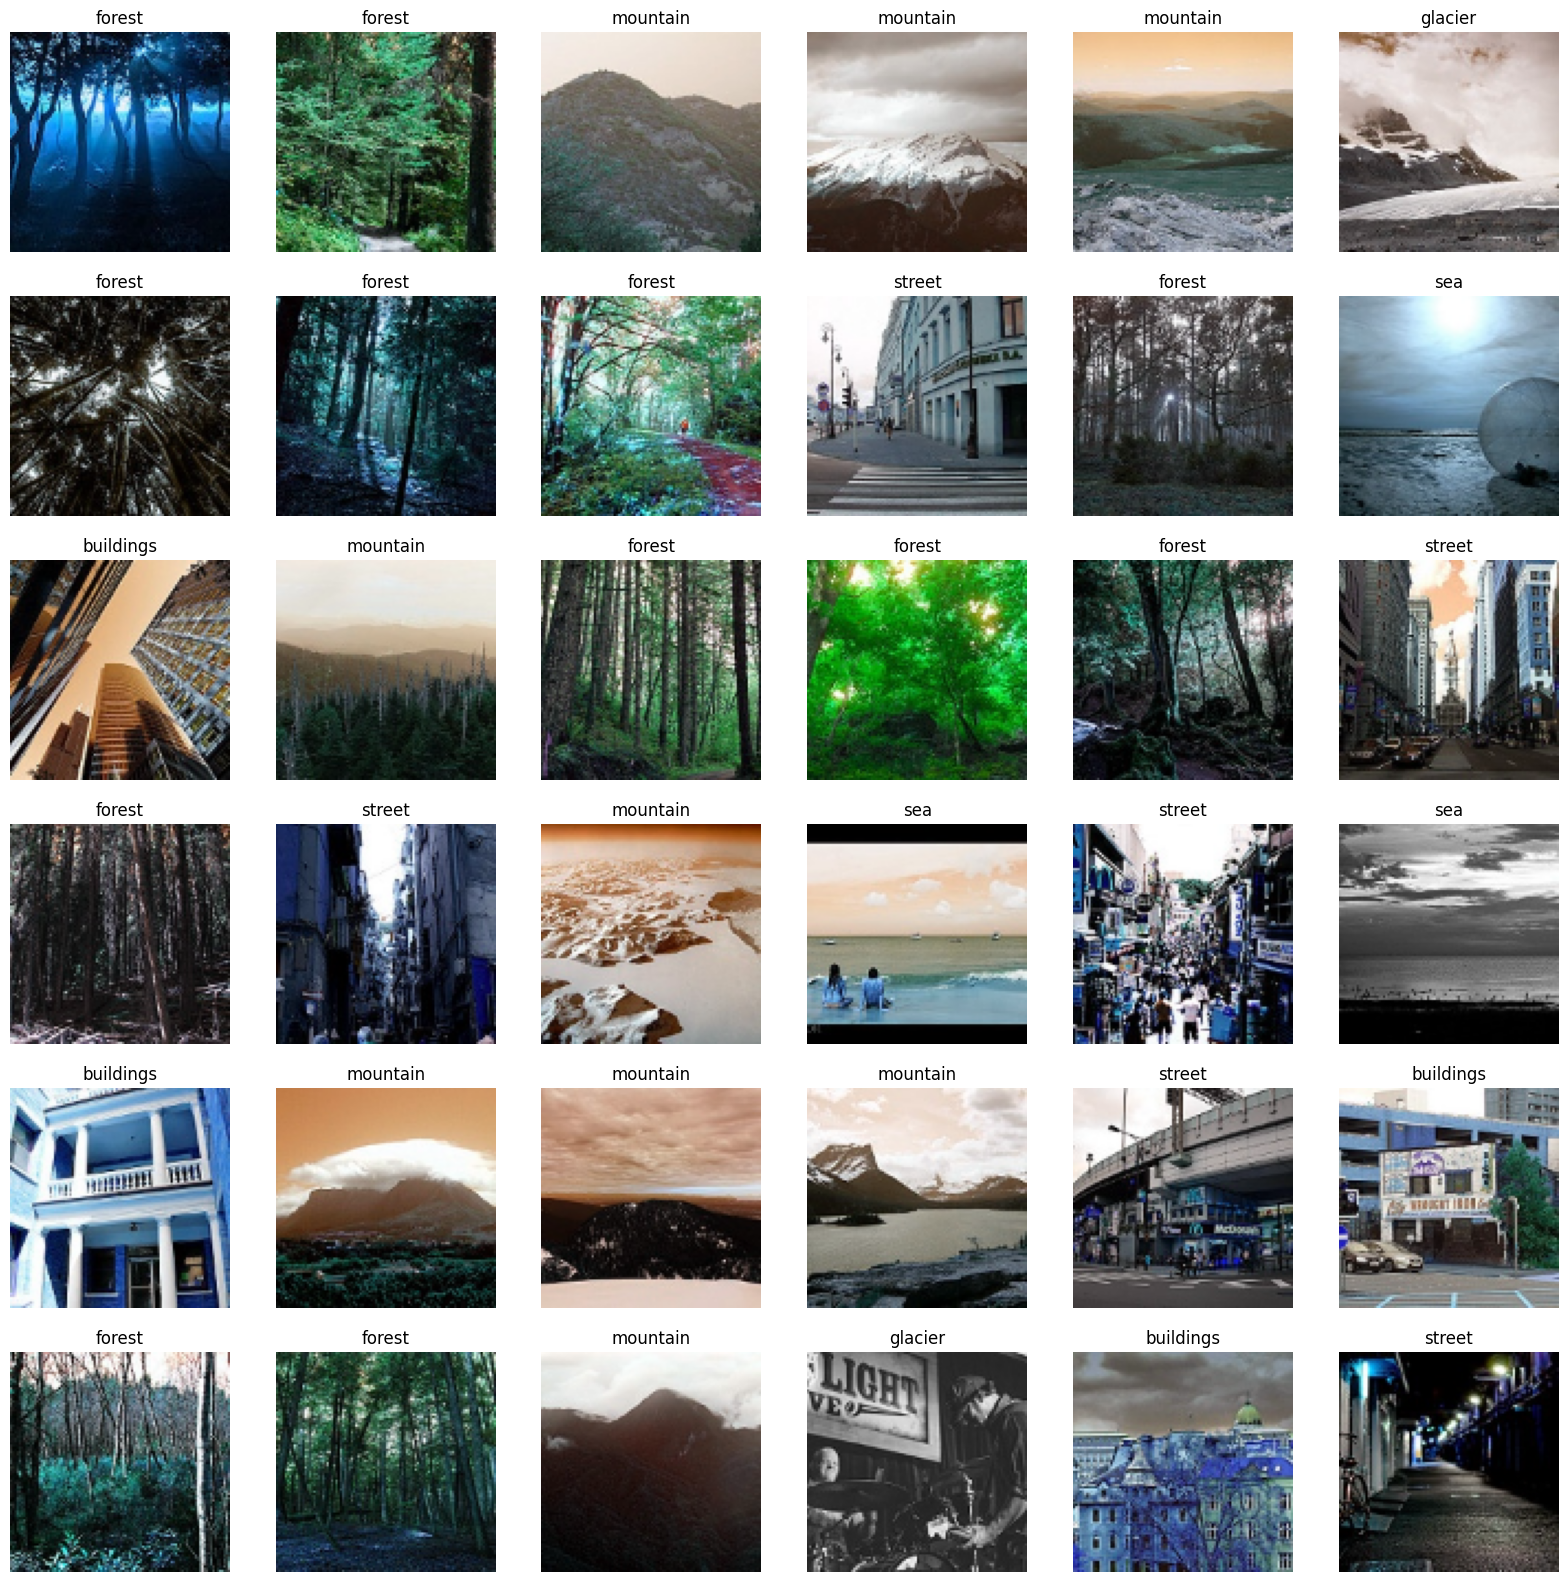

In [ ]:
plt.figure(figsize=(20,20))
for n,i in enumerate(list(np.random.randint(0,len(x_train),36))):
    plt.subplot(6,6,n+1)
    plt.imshow(x_train[i].reshape(s,s,3))
    plt.axis('off')
    plt.title(get_target_label(y_train[i]))

# Creating Convolutional Neural Network

### Converting the data to arrays

In [ ]:
x_train=np.array(x_train).reshape(-1,100,100,3)
x_test=np.array(x_test).reshape(-1,100,100,3)
x_pred=np.array(x_pred).reshape(-1,100,100,3)
y_train=np.array(y_train)
y_test=np.array(y_test)

print(f"x_train shape is {x_train.shape}\n"
      f"x_test shape is {x_test.shape}\n"
      f"x_pred shape is {x_pred.shape}\n"
      f"y_train shape is {y_train.shape}\n"
      f"y_test shape is {y_test.shape}")

x_train shape is (14034, 100, 100, 3)
x_test shape is (3000, 100, 100, 3)
x_pred shape is (7301, 100, 100, 3)
y_train shape is (14034,)
y_test shape is (3000,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import regularizers

# Define your model
KerasModel = keras.models.Sequential([
    keras.layers.Conv2D(2, kernel_size=(3, 3), activation='relu', input_shape=(s, s, 3), kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Conv2D(150, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPool2D(4, 4),
    keras.layers.Conv2D(120, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Conv2D(80, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Conv2D(50, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPool2D(4, 4),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(6, activation='softmax'),
])

# Compile the model
KerasModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set the number of epochs
epochs = 10

# Fit the model with validation_split
ThisModel = KerasModel.fit(
    x_train, 
    y_train, 
    epochs=epochs, 
    batch_size=64, 
    verbose=1
)

# Evaluate the model on the test data
model_loss, model_accuracy = KerasModel.evaluate(x_test, y_test)
print('Test Loss is {}'.format(model_loss))
print('Test Accuracy is {}'.format(model_accuracy))


Epoch 1/200
220/220 [==============================] - 26s 86ms/step - loss: 5.3313 - accuracy: 0.4717
Epoch 2/200
220/220 [==============================] - 19s 86ms/step - loss: 3.3168 - accuracy: 0.6315
Epoch 3/200
220/220 [==============================] - 19s 85ms/step - loss: 2.5800 - accuracy: 0.6893
Epoch 4/200
220/220 [==============================] - 19s 85ms/step - loss: 2.1159 - accuracy: 0.7195
Epoch 5/200
220/220 [==============================] - 18s 84ms/step - loss: 1.7611 - accuracy: 0.7447
Epoch 6/200
220/220 [==============================] - 19s 84ms/step - loss: 1.5097 - accuracy: 0.7581
Epoch 7/200
220/220 [==============================] - 18s 83ms/step - loss: 1.3212 - accuracy: 0.7713
Epoch 8/200
220/220 [==============================] - 18s 83ms/step - loss: 1.1958 - accuracy: 0.7747
Epoch 9/200
220/220 [==============================] - 18s 82ms/step - loss: 1.0949 - accuracy: 0.7795
Epoch 10/200
220/220 [==============================] - 18s 83ms/step - l

229/229 [==============================] - 2s 10ms/step


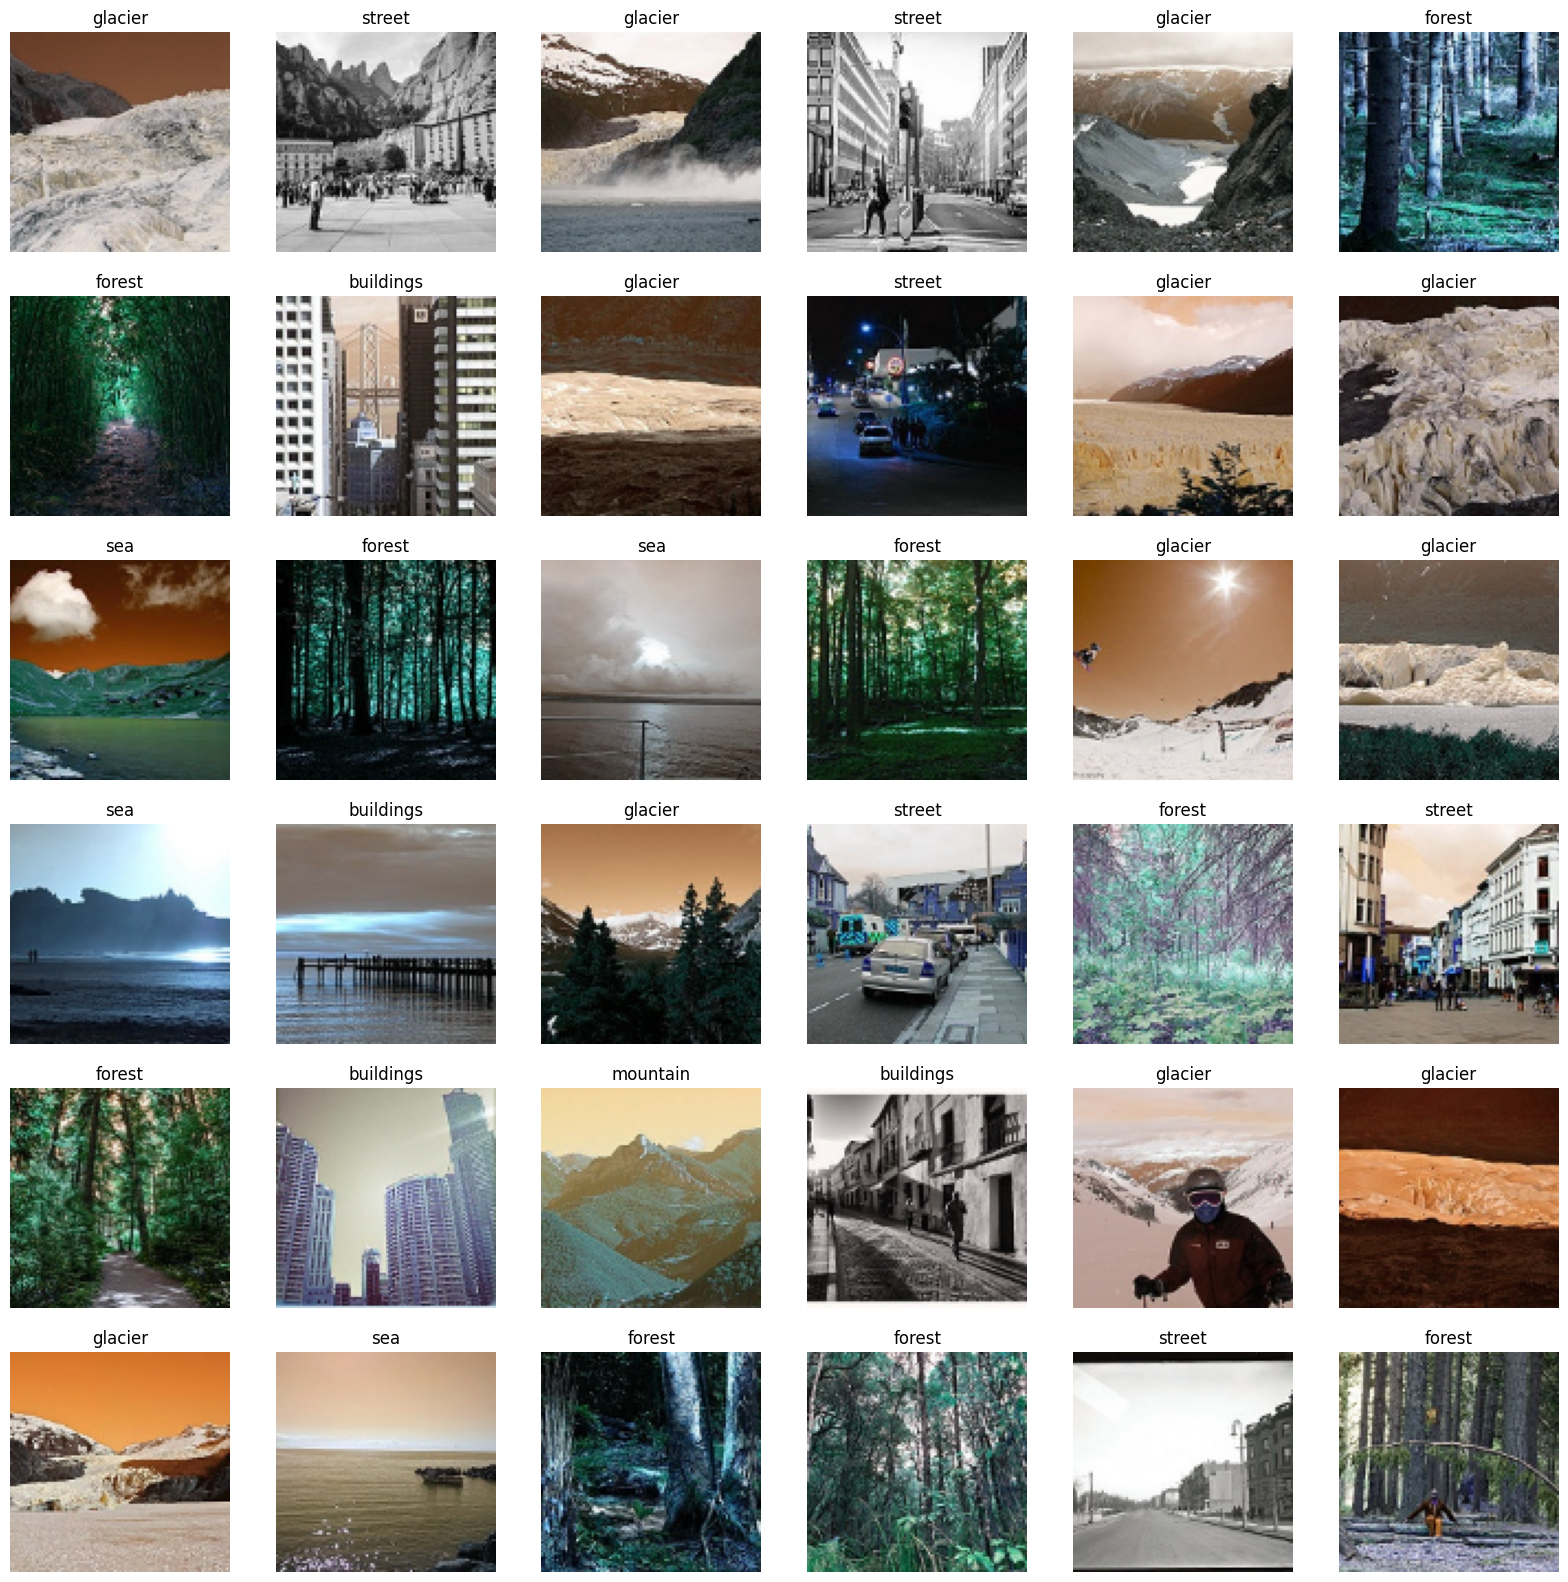

In [ ]:
y_result = KerasModel.predict(x_pred)

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])    
    plt.axis('off')
    plt.title(get_target_label(np.argmax(y_result[i])))